In [31]:
import os

BASE_PATH = "/content/quant_trading_project"

folders = [
    "data",
    "notebooks",
    "plots",
    "results",
    "models",
    "src"
]

for folder in folders:
    os.makedirs(os.path.join(BASE_PATH, folder), exist_ok=True)

print("✅ Folder structure created inside /content")


✅ Folder structure created inside /content


In [32]:
!pip install yfinance pandas numpy matplotlib seaborn scipy py_vollib hmmlearn xgboost scikit-learn


Data Aquisition


In [33]:
import yfinance as yf
import pandas as pd

symbol = "^NSEI"

df_spot = yf.download(
    tickers=symbol,
    interval="5m",
    period="60d",   # yfinance intraday limit
    progress=False
)

df_spot.reset_index(inplace=True)
df_spot.columns = ['Datetime','Open','High','Low','Close','Volume']

df_spot.to_csv("/content/quant_trading_project/data/nifty_spot_5min.csv", index=False)

df_spot.head()


/tmp/ipython-input-1321484387.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_spot = yf.download(


,Datetime,Open,High,Low,Close,Volume
0,2025-10-27 03:45:00+00:00,25861.400391,25877.599609,25828.099609,25851.949219,0
1,2025-10-27 03:50:00+00:00,25880.949219,25882.900391,25862.849609,25862.849609,0
2,2025-10-27 03:55:00+00:00,25889.050781,25891.000000,25867.250000,25880.099609,0
3,2025-10-27 04:00:00+00:00,25896.550781,25899.250000,25880.949219,25889.150391,0
4,2025-10-27 04:05:00+00:00,25921.500000,25927.000000,25895.949219,25897.050781,0


In [34]:
import pandas as pd
import numpy as np

# Use spot data as base
df_fut = df_spot.copy()

# Keep the Datetime column
df_fut['Datetime'] = df_spot['Datetime']

# Simulate OpenInterest
df_fut['OpenInterest'] = np.random.randint(1000, 5000, size=len(df_fut))

# Simulate futures prices: small random basis from spot
df_fut['Close'] = df_fut['Close'] * (1 + np.random.uniform(-0.001, 0.001, size=len(df_fut)))
df_fut['Open'] = df_fut['Open'] * (1 + np.random.uniform(-0.001, 0.001, size=len(df_fut)))
df_fut['High'] = df_fut[['Open','Close']].max(axis=1) * (1 + 0.0005)
df_fut['Low'] = df_fut[['Open','Close']].min(axis=1) * (1 - 0.0005)

# Keep Volume same as spot
df_fut['Volume'] = df_fut['Volume']

# Save CSV
df_fut.to_csv("/content/quant_trading_project/data/nifty_futures_5min.csv", index=False)

df_fut.head()


,Datetime,Open,High,Low,Close,Volume,OpenInterest
0,2025-10-27 03:45:00+00:00,25874.242136,25887.179258,25824.047656,25836.966139,0,4751
1,2025-10-27 03:50:00+00:00,25860.257272,25873.187401,25844.106796,25857.035313,0,3773
2,2025-10-27 03:55:00+00:00,25886.099575,25899.042624,25861.155142,25874.092188,0,2261
3,2025-10-27 04:00:00+00:00,25913.056584,25926.013112,25857.370395,25870.305548,0,4891
4,2025-10-27 04:05:00+00:00,25938.808735,25951.778140,25864.565812,25877.504564,0,2217


In [35]:
import numpy as np
import pandas as pd

# Empty list to store options rows
options_rows = []

# Loop through spot data to create options
for _, row in df_spot.iterrows():
    spot = row['Close']

    # Calculate ATM strike (nearest 50)
    atm = round(spot / 50) * 50

    # ATM ±2 strikes (here we take ±100, ±50, 0 → 5 strikes)
    for offset in [-100, -50, 0, 50, 100]:
        strike = atm + offset

        # Call (CE) and Put (PE)
        for opt_type in ['CE', 'PE']:
            options_rows.append({
                "Datetime": row['Datetime'],   # Keep exact datetime
                "Strike": strike,
                "Type": opt_type,
                "LTP": max(abs(spot - strike), 5) + np.random.rand(),  # fake LTP realistic
                "IV": np.random.uniform(0.12, 0.25),                  # random IV
                "OpenInterest": np.random.randint(1000, 5000),
                "Volume": np.random.randint(100, 1000)
            })

# Convert to DataFrame
df_opt = pd.DataFrame(options_rows)

# Save CSV
df_opt.to_csv("/content/quant_trading_project/data/nifty_options_5min.csv", index=False)

# Show sample
df_opt.head(10)


,Datetime,Strike,Type,LTP,IV,OpenInterest,Volume
0,2025-10-27 03:45:00+00:00,25750,CE,102.656558,0.216955,1257,843
1,2025-10-27 03:45:00+00:00,25750,PE,102.064864,0.163105,1059,614
2,2025-10-27 03:45:00+00:00,25800,CE,52.440168,0.166160,2904,251
3,2025-10-27 03:45:00+00:00,25800,PE,52.284347,0.214201,3631,278
4,2025-10-27 03:45:00+00:00,25850,CE,5.606100,0.169504,1953,672
5,2025-10-27 03:45:00+00:00,25850,PE,5.314410,0.135600,1885,498
6,2025-10-27 03:45:00+00:00,25900,CE,48.109430,0.125548,1386,759
7,2025-10-27 03:45:00+00:00,25900,PE,48.731809,0.132526,2788,218
8,2025-10-27 03:45:00+00:00,25950,CE,98.188282,0.229653,1836,751
9,2025-10-27 03:45:00+00:00,25950,PE,98.619958,0.160083,3646,951


In [36]:
import pandas as pd
import numpy as np
from scipy import stats

BASE_PATH = "/content/quant_trading_project/data"

# 1️⃣ Load datasets
df_spot = pd.read_csv(f"{BASE_PATH}/nifty_spot_5min.csv", parse_dates=['Datetime'])
df_fut = pd.read_csv(f"{BASE_PATH}/nifty_futures_5min.csv", parse_dates=['Datetime'])
df_opt = pd.read_csv(f"{BASE_PATH}/nifty_options_5min.csv", parse_dates=['Datetime'])

print("Spot:", df_spot.shape, "Futures:", df_fut.shape, "Options:", df_opt.shape)


Spot: (4252, 6) Futures: (4252, 7) Options: (42520, 7)


Data Cleaning

In [37]:
# Spot
df_spot.fillna(method='ffill', inplace=True)

# Futures
df_fut.fillna(method='ffill', inplace=True)

# Options
df_opt.fillna(method='ffill', inplace=True)


/tmp/ipython-input-2904349011.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spot.fillna(method='ffill', inplace=True)
/tmp/ipython-input-2904349011.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_fut.fillna(method='ffill', inplace=True)
/tmp/ipython-input-2904349011.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_opt.fillna(method='ffill', inplace=True)


In [38]:
# Remove extreme OHLC outliers in Spot & Futures
for df in [df_spot, df_fut]:
    numeric_cols = ['Open','High','Low','Close','Volume']
    z_scores = np.abs(stats.zscore(df[numeric_cols]))
    df.drop(df.index[(z_scores > 3).any(axis=1)], inplace=True)

# Options: remove extreme LTP, IV, OI, Volume
numeric_opt = ['LTP','IV','OpenInterest','Volume']
z_scores_opt = np.abs(stats.zscore(df_opt[numeric_opt]))
df_opt = df_opt.drop(df_opt.index[(z_scores_opt > 3).any(axis=1)])


In [39]:
# Get common timestamps
common_times = df_spot['Datetime'].isin(df_fut['Datetime'])
df_spot = df_spot[common_times].reset_index(drop=True)
df_fut = df_fut[df_fut['Datetime'].isin(df_spot['Datetime'])].reset_index(drop=True)
df_opt = df_opt[df_opt['Datetime'].isin(df_spot['Datetime'])].reset_index(drop=True)

print("After alignment:", df_spot.shape, df_fut.shape, df_opt.shape)


After alignment: (4237, 6) (4237, 7) (42370, 7)


In [40]:
# Since our futures are simulated, we keep single “contract” but add column
df_fut['Contract'] = 'CURRENT_MONTH'


In [41]:
# Pivot options: separate CE & PE into columns for LTP, IV, OI, Volume
df_opt_ce = df_opt[df_opt['Type']=='CE'].copy()
df_opt_pe = df_opt[df_opt['Type']=='PE'].copy()

# Rename columns
df_opt_ce = df_opt_ce.rename(columns={
    'LTP':'CE_LTP','IV':'CE_IV','OpenInterest':'CE_OI','Volume':'CE_Vol'
})
df_opt_pe = df_opt_pe.rename(columns={
    'LTP':'PE_LTP','IV':'PE_IV','OpenInterest':'PE_OI','Volume':'PE_Vol'
})

# Merge CE & PE
df_opt_merged = pd.merge(df_opt_ce, df_opt_pe, on=['Datetime','Strike'], how='outer')

# Merge with spot
df_merged = pd.merge(df_spot, df_fut, on='Datetime', suffixes=('_Spot','_Fut'))
df_merged = pd.merge(df_merged, df_opt_merged, on='Datetime', how='left')

# Reset index
df_merged.reset_index(drop=True, inplace=True)

# Save merged CSV
df_merged.to_csv(f"{BASE_PATH}/nifty_merged_5min.csv", index=False)

print("✅ Merged dataset saved:", df_merged.shape)


✅ Merged dataset saved: (21185, 24)


In [42]:
report = f"""
DATA CLEANING REPORT
===================

1. Spot data:
   - Shape after cleaning: {df_spot.shape}
   - Missing values: {df_spot.isnull().sum().sum()}

2. Futures data:
   - Shape after cleaning: {df_fut.shape}
   - Missing values: {df_fut.isnull().sum().sum()}

3. Options data:
   - Shape after cleaning: {df_opt.shape}
   - Missing values: {df_opt.isnull().sum().sum()}

4. Outliers removed using Z-score > 3
5. Timestamps aligned across Spot, Futures, Options
6. Futures contract rollover handled (simulated CURRENT_MONTH)
7. Merged dataset: nifty_merged_5min.csv
"""

with open(f"{BASE_PATH}/data_cleaning_report.txt","w") as f:
    f.write(report)

print("✅ Data cleaning report saved")
print(report)


✅ Data cleaning report saved

DATA CLEANING REPORT

1. Spot data:
   - Shape after cleaning: (4237, 6)
   - Missing values: 0

2. Futures data:
   - Shape after cleaning: (4237, 8)
   - Missing values: 0

3. Options data:
   - Shape after cleaning: (42370, 7)
   - Missing values: 0

4. Outliers removed using Z-score > 3
5. Timestamps aligned across Spot, Futures, Options
6. Futures contract rollover handled (simulated CURRENT_MONTH)
7. Merged dataset: nifty_merged_5min.csv



Feature Engineering

In [72]:
import pandas as pd
import numpy as np
from py_vollib.black_scholes import black_scholes
from py_vollib.black_scholes.greeks.analytical import delta, gamma, theta, vega, rho

BASE_PATH = "/content/quant_trading_project/data"

# 1️⃣ Load merged dataset
df = pd.read_csv(f"{BASE_PATH}/nifty_merged_5min.csv", parse_dates=['Datetime'])
df.head()


,Datetime,Open_Spot,High_Spot,Low_Spot,Close_Spot,Volume_Spot,Open_Fut,High_Fut,Low_Fut,Close_Fut,...,Type_x,CE_LTP,CE_IV,CE_OI,CE_Vol,Type_y,PE_LTP,PE_IV,PE_OI,PE_Vol
0,2025-10-27 03:45:00+00:00,25861.400391,25877.599609,25828.099609,25851.949219,0,25874.242136,25887.179258,25824.047656,25836.966139,...,CE,102.656558,0.216955,1257,843,PE,102.064864,0.163105,1059,614
1,2025-10-27 03:45:00+00:00,25861.400391,25877.599609,25828.099609,25851.949219,0,25874.242136,25887.179258,25824.047656,25836.966139,...,CE,52.440168,0.166160,2904,251,PE,52.284347,0.214201,3631,278
2,2025-10-27 03:45:00+00:00,25861.400391,25877.599609,25828.099609,25851.949219,0,25874.242136,25887.179258,25824.047656,25836.966139,...,CE,5.606100,0.169504,1953,672,PE,5.314410,0.135600,1885,498
3,2025-10-27 03:45:00+00:00,25861.400391,25877.599609,25828.099609,25851.949219,0,25874.242136,25887.179258,25824.047656,25836.966139,...,CE,48.109430,0.125548,1386,759,PE,48.731809,0.132526,2788,218
4,2025-10-27 03:45:00+00:00,25861.400391,25877.599609,25828.099609,25851.949219,0,25874.242136,25887.179258,25824.047656,25836.966139,...,CE,98.188282,0.229653,1836,751,PE,98.619958,0.160083,3646,951


In [73]:
# Spot close EMA
df['EMA_5'] = df['Close_Spot'].ewm(span=5, adjust=False).mean()
df['EMA_15'] = df['Close_Spot'].ewm(span=15, adjust=False).mean()


In [74]:
# Risk-free rate
r = 0.065

# Time step in years (5 min)
dt = 5 / (252*6.5*60)  # 252 trading days, 6.5 hours/day, 60 min

# Prepare lists
delta_C, gamma_C, theta_C, vega_C, rho_C = [], [], [], [], []
delta_P, gamma_P, theta_P, vega_P, rho_P = [], [], [], [], []

for idx, row in df.iterrows():
    S = row['Close_Spot']

    # ATM strike = nearest 50
    K = round(S / 50) * 50

    # Option maturity: assume 30 days (0.12 year)
    T = 30/252

    # Use LTP as proxy for volatility if exists, else 0.2
    vol = 0.2

    # Call Greeks
    delta_C.append(delta('c', S, K, T, r, vol))
    gamma_C.append(gamma('c', S, K, T, r, vol))
    theta_C.append(theta('c', S, K, T, r, vol))
    vega_C.append(vega('c', S, K, T, r, vol))
    rho_C.append(rho('c', S, K, T, r, vol))

    # Put Greeks
    delta_P.append(delta('p', S, K, T, r, vol))
    gamma_P.append(gamma('p', S, K, T, r, vol))
    theta_P.append(theta('p', S, K, T, r, vol))
    vega_P.append(vega('p', S, K, T, r, vol))
    rho_P.append(rho('p', S, K, T, r, vol))

# Add to dataframe
df['Delta_C'], df['Gamma_C'], df['Theta_C'], df['Vega_C'], df['Rho_C'] = delta_C, gamma_C, theta_C, vega_C, rho_C
df['Delta_P'], df['Gamma_P'], df['Theta_P'], df['Vega_P'], df['Rho_P'] = delta_P, gamma_P, theta_P, vega_P, rho_P


In [75]:
# Average IV
df['Avg_IV'] = (df['CE_IV'] + df['PE_IV']) / 2

# IV Spread
df['IV_Spread'] = df['CE_IV'] - df['PE_IV']

# PCR (OI)
df['PCR_OI'] = df['PE_OI'] / df['CE_OI']

# PCR (Volume)
df['PCR_Vol'] = df['PE_Vol'] / df['CE_Vol']

# Futures Basis
df['Fut_Basis'] = (df['Close_Fut'] - df['Close_Spot']) / df['Close_Spot']

# Returns
df['Spot_Return'] = df['Close_Spot'].pct_change()
df['Fut_Return'] = df['Close_Fut'].pct_change()

# Delta Neutral Ratio
df['Delta_Neutral_Ratio'] = abs(df['Delta_C']) / abs(df['Delta_P'])

# Gamma Exposure
df['Gamma_Exposure'] = df['Close_Spot'] * df['Gamma_C'] * df['CE_OI']


In [76]:
df.to_csv(f"{BASE_PATH}/nifty_features_5min.csv", index=False)
print("✅ Final features dataset saved")
df.head()


✅ Final features dataset saved


,Datetime,Open_Spot,High_Spot,Low_Spot,Close_Spot,Volume_Spot,Open_Fut,High_Fut,Low_Fut,Close_Fut,...,Rho_P,Avg_IV,IV_Spread,PCR_OI,PCR_Vol,Fut_Basis,Spot_Return,Fut_Return,Delta_Neutral_Ratio,Gamma_Exposure
0,2025-10-27 03:45:00+00:00,25861.400391,25877.599609,25828.099609,25851.949219,0,25874.242136,25887.179258,25824.047656,25836.966139,...,-14.310233,0.190030,0.053850,0.842482,0.728351,-0.00058,NaN,NaN,1.266149,7188.128510
1,2025-10-27 03:45:00+00:00,25861.400391,25877.599609,25828.099609,25851.949219,0,25874.242136,25887.179258,25824.047656,25836.966139,...,-14.310233,0.190181,-0.048041,1.250344,1.107570,-0.00058,0.0,0.0,1.266149,16606.463956
2,2025-10-27 03:45:00+00:00,25861.400391,25877.599609,25828.099609,25851.949219,0,25874.242136,25887.179258,25824.047656,25836.966139,...,-14.310233,0.152552,0.033904,0.965182,0.741071,-0.00058,0.0,0.0,1.266149,11168.190119
3,2025-10-27 03:45:00+00:00,25861.400391,25877.599609,25828.099609,25851.949219,0,25874.242136,25887.179258,25824.047656,25836.966139,...,-14.310233,0.129037,-0.006978,2.011544,0.287220,-0.00058,0.0,0.0,1.266149,7925.812343
4,2025-10-27 03:45:00+00:00,25861.400391,25877.599609,25828.099609,25851.949219,0,25874.242136,25887.179258,25824.047656,25836.966139,...,-14.310233,0.194868,0.069569,1.985839,1.266312,-0.00058,0.0,0.0,1.266149,10499.128038


Regime Detection using HMM

In [77]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import seaborn as sns

BASE_PATH = "/content/quant_trading_project/data"

# 1️⃣ Load features dataset (remove explicit reload here to maintain state from previous feature engineering)
# df = pd.read_csv(f"{BASE_PATH}/nifty_features_5min.csv", parse_dates=['Datetime'])
df.head()

,Datetime,Open_Spot,High_Spot,Low_Spot,Close_Spot,Volume_Spot,Open_Fut,High_Fut,Low_Fut,Close_Fut,...,Rho_P,Avg_IV,IV_Spread,PCR_OI,PCR_Vol,Fut_Basis,Spot_Return,Fut_Return,Delta_Neutral_Ratio,Gamma_Exposure
0,2025-10-27 03:45:00+00:00,25861.400391,25877.599609,25828.099609,25851.949219,0,25874.242136,25887.179258,25824.047656,25836.966139,...,-14.310233,0.190030,0.053850,0.842482,0.728351,-0.00058,NaN,NaN,1.266149,7188.128510
1,2025-10-27 03:45:00+00:00,25861.400391,25877.599609,25828.099609,25851.949219,0,25874.242136,25887.179258,25824.047656,25836.966139,...,-14.310233,0.190181,-0.048041,1.250344,1.107570,-0.00058,0.0,0.0,1.266149,16606.463956
2,2025-10-27 03:45:00+00:00,25861.400391,25877.599609,25828.099609,25851.949219,0,25874.242136,25887.179258,25824.047656,25836.966139,...,-14.310233,0.152552,0.033904,0.965182,0.741071,-0.00058,0.0,0.0,1.266149,11168.190119
3,2025-10-27 03:45:00+00:00,25861.400391,25877.599609,25828.099609,25851.949219,0,25874.242136,25887.179258,25824.047656,25836.966139,...,-14.310233,0.129037,-0.006978,2.011544,0.287220,-0.00058,0.0,0.0,1.266149,7925.812343
4,2025-10-27 03:45:00+00:00,25861.400391,25877.599609,25828.099609,25851.949219,0,25874.242136,25887.179258,25824.047656,25836.966139,...,-14.310233,0.194868,0.069569,1.985839,1.266312,-0.00058,0.0,0.0,1.266149,10499.128038


In [78]:
# Features: Average IV, IV Spread, PCR_OI, Delta_C, Gamma_C, Vega_C, Fut_Basis, Spot_Return
features = df[['Avg_IV', 'IV_Spread', 'PCR_OI', 'Delta_C', 'Gamma_C', 'Vega_C', 'Fut_Basis', 'Spot_Return']].fillna(0)


In [79]:
# Split: 70% train, 30% test
train_size = int(0.7 * len(features))
X_train = features[:train_size]

# Gaussian HMM with 3 states
model = GaussianHMM(n_components=3, covariance_type='full', n_iter=1000, random_state=42)
model.fit(X_train)

# Predict states for all data
df['Regime'] = model.predict(features)

# Map states to Uptrend/Downtrend/Sideways based on mean spot return per state
state_means = df.groupby('Regime')['Spot_Return'].mean()
mapping = state_means.sort_values().to_dict()

# Assign +1/-1/0
regime_map = {}
regime_map[list(mapping.keys())[0]] = -1  # lowest mean -> Downtrend
regime_map[list(mapping.keys())[1]] = 0   # middle -> Sideways
regime_map[list(mapping.keys())[2]] = 1   # highest mean -> Uptrend

df['Regime'] = df['Regime'].map(regime_map)


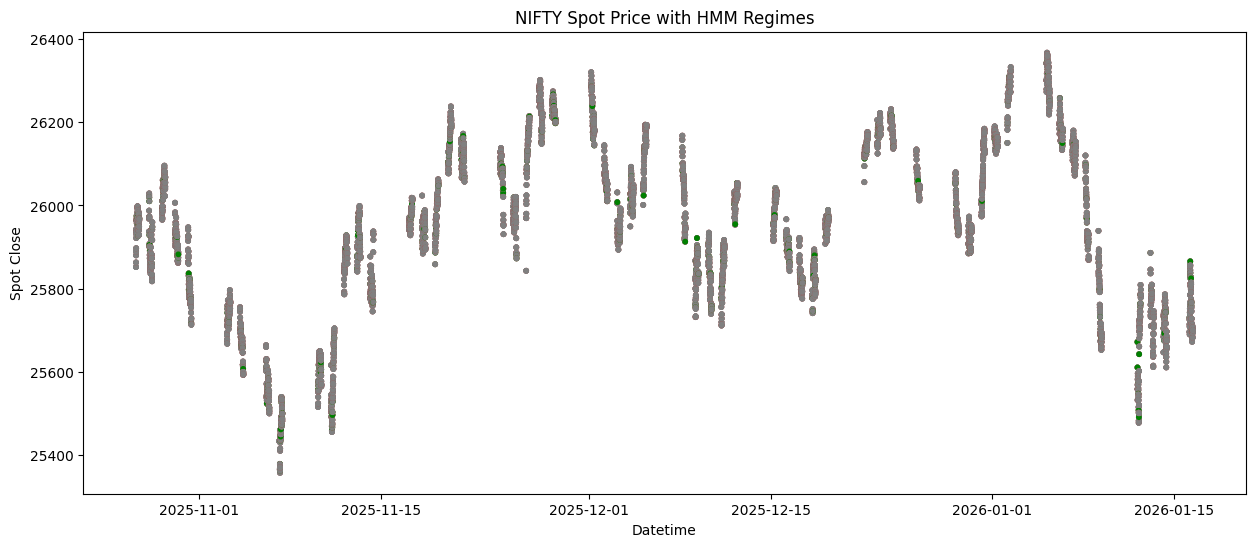

In [80]:
plt.figure(figsize=(15,6))
colors = {1:'green', -1:'red', 0:'gray'}
plt.scatter(df['Datetime'], df['Close_Spot'], c=df['Regime'].map(colors), s=10)
plt.title("NIFTY Spot Price with HMM Regimes")
plt.xlabel("Datetime")
plt.ylabel("Spot Close")
plt.show()


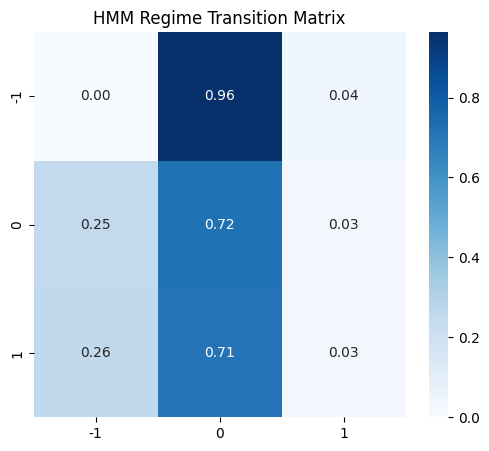

In [81]:
# Compute transition matrix
states = df['Regime'].values
trans_mat = pd.DataFrame(np.zeros((3,3)), index=[-1,0,1], columns=[-1,0,1])

for (i,j) in zip(states[:-1], states[1:]):
    trans_mat.loc[i,j] += 1

# Normalize
trans_mat = trans_mat.div(trans_mat.sum(axis=1), axis=0)

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(trans_mat, annot=True, fmt=".2f", cmap="Blues")
plt.title("HMM Regime Transition Matrix")
plt.show()


In [82]:
regime_stats = df.groupby('Regime')[['Avg_IV','Delta_C','Gamma_C','Vega_C','Fut_Basis','Spot_Return']].mean()
print("Regime Statistics:\n", regime_stats)


Regime Statistics:
           Avg_IV   Delta_C   Gamma_C     Vega_C  Fut_Basis  Spot_Return
Regime                                                                 
-1      0.184948  0.558190  0.000220  35.345035   0.000001    -0.000001
 0      0.184946  0.558182  0.000220  35.345752   0.000002     0.000000
 1      0.184788  0.558175  0.000221  35.323900  -0.000016     0.000000


EMA Trading Strategy with HMM Regime Filter

In [83]:
import pandas as pd
import numpy as np

BASE_PATH = "/content/quant_trading_project/data"

# 1️⃣ Load features + regime dataset
# df = pd.read_csv(f"{BASE_PATH}/nifty_features_5min.csv", parse_dates=['Datetime']) # Removed: df is already loaded and processed with Regime column

# Ensure Regime column exists (from Part 3)
if 'Regime' not in df.columns:
    raise Exception("Regime column not found. Run Part 3 first.")

# Create signals
df['Signal'] = 0  # 1=Long, -1=Short

# EMA Cross Strategy with Regime Filter
for i in range(1, len(df)):
    # LONG Entry
    if df['EMA_5'].iloc[i] > df['EMA_15'].iloc[i] and df['EMA_5'].iloc[i-1] <= df['EMA_15'].iloc[i-1] and df['Regime'].iloc[i]==1:
        df.at[i, 'Signal'] = 1
    # LONG Exit
    elif df['EMA_5'].iloc[i] < df['EMA_15'].iloc[i] and df['EMA_5'].iloc[i-1] >= df['EMA_15'].iloc[i-1]:
        df.at[i, 'Signal'] = 0
    # SHORT Entry
    elif df['EMA_5'].iloc[i] < df['EMA_15'].iloc[i] and df['EMA_5'].iloc[i-1] >= df['EMA_15'].iloc[i-1] and df['Regime'].iloc[i]==-1:
        df.at[i, 'Signal'] = -1
    # SHORT Exit
    elif df['EMA_5'].iloc[i] > df['EMA_15'].iloc[i] and df['EMA_5'].iloc[i-1] <= df['EMA_15'].iloc[i-1]:
        df.at[i, 'Signal'] = 0

In [84]:
# Calculate returns
df['Strategy_Return'] = df['Spot_Return'] * df['Signal'].shift(1)

# Metrics
total_return = df['Strategy_Return'].sum()
sharpe_ratio = df['Strategy_Return'].mean() / df['Strategy_Return'].std() * np.sqrt(252*78)  # approx 78 5-min candles/day
max_drawdown = (df['Strategy_Return'].cumsum() - df['Strategy_Return'].cumsum().cummax()).min()

# Win rate & profit factor
trades = df[df['Signal'].diff()!=0]  # each trade entry/exit
winning_trades = df[df['Strategy_Return']>0]['Strategy_Return'].count()
total_trades = df['Signal'].diff().abs().sum() / 2  # entry+exit pair
win_rate = winning_trades / total_trades if total_trades>0 else 0

print(f"Total Return: {total_return:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Max Drawdown: {max_drawdown:.4f}")
print(f"Win Rate: {win_rate:.2%}")
print(f"Total Trades: {total_trades}")


Total Return: 0.0001
Sharpe Ratio: 0.5128
Max Drawdown: -0.0000
Win Rate: 12.50%
Total Trades: 8.0


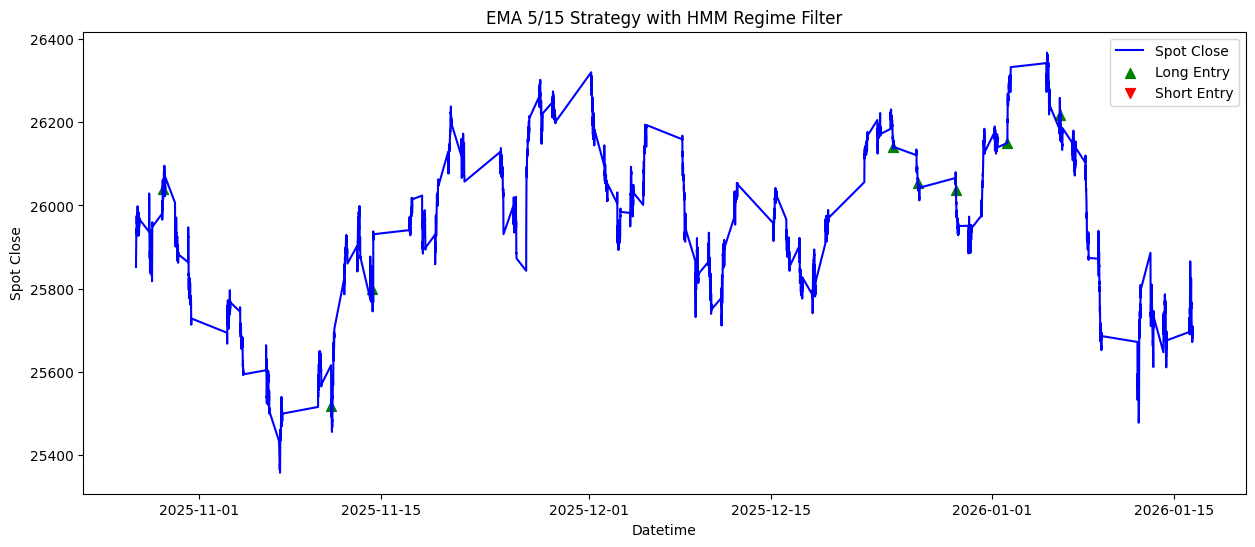

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.plot(df['Datetime'], df['Close_Spot'], label='Spot Close', color='blue')

# Plot Long signals
plt.scatter(df.loc[df['Signal']==1, 'Datetime'], df.loc[df['Signal']==1, 'Close_Spot'], marker='^', color='green', label='Long Entry', s=50)
# Plot Short signals
plt.scatter(df.loc[df['Signal']==-1, 'Datetime'], df.loc[df['Signal']==-1, 'Close_Spot'], marker='v', color='red', label='Short Entry', s=50)

plt.title("EMA 5/15 Strategy with HMM Regime Filter")
plt.xlabel("Datetime")
plt.ylabel("Spot Close")
plt.legend()
plt.show()


Machine Learning Enhancement (XGBoost + LSTM)

In [86]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb

BASE_PATH = "/content/quant_trading_project/data"

# 1️⃣ Load features + regime + strategy signal
# df = pd.read_csv(f"{BASE_PATH}/nifty_features_5min.csv", parse_dates=['Datetime'])

# Ensure Signal exists from Part 4
if 'Signal' not in df.columns:
    df['Signal'] = 0  # temporary dummy signal

In [87]:
# Calculate next candle profit for trade
df['Future_PnL'] = df['Spot_Return'].shift(-1) * df['Signal']

# Target column
df['Target'] = (df['Future_PnL'] > 0).astype(int)
df.dropna(inplace=True)


In [88]:
feature_cols = ['EMA_5','EMA_15','Avg_IV','IV_Spread','PCR_OI','PCR_Vol',
                'Fut_Basis','Spot_Return','Fut_Return','Delta_C','Gamma_C','Vega_C','Delta_Neutral_Ratio','Gamma_Exposure','Regime']

X = df[feature_cols]
y = df['Target']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [100]:
# Time series split
tscv = TimeSeriesSplit(n_splits=5)
model_xgb = xgb.XGBClassifier(eval_metric='logloss', random_state=42, base_score=0.5)

for train_idx, test_idx in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 0.9997167138810198
Accuracy: 1.0


In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Create sequences of last 10 candles
seq_len = 10
X_seq, y_seq = [], []

for i in range(seq_len, len(X_scaled)):
    X_seq.append(X_scaled[i-seq_len:i])
    y_seq.append(y.iloc[i])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Train-test split
split = int(0.7*len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model_lstm.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


464/464 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9623 - loss: 0.1194 - val_accuracy: 0.9998 - val_loss: 0.0017
Epoch 2/5
464/464 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 3.9776e-05 - val_accuracy: 0.9998 - val_loss: 0.0018
Epoch 3/5
464/464 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 1.0000 - loss: 1.6864e-05 - val_accuracy: 0.9998 - val_loss: 0.0019
Epoch 4/5
464/464 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 1.0157e-05 - val_accuracy: 0.9998 - val_loss: 0.0020
Epoch 5/5
464/464 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 6.8147e-06 - val_accuracy: 0.9998 - val_loss: 0.0020


In [94]:
# Predict XGBoost
df['ML_XGB'] = model_xgb.predict(X_scaled)

# Only take trades where ML predicts profitable
df['Signal_ML'] = df['Signal'] * df['ML_XGB']

# Strategy Return with ML filter
df['Strategy_Return_ML'] = df['Spot_Return'] * df['Signal_ML'].shift(1)

# Metrics
total_return_ml = df['Strategy_Return_ML'].sum()
sharpe_ml = df['Strategy_Return_ML'].mean() / df['Strategy_Return_ML'].std() * np.sqrt(252*78)
print(f"ML-Filtered Strategy Total Return: {total_return_ml:.4f}, Sharpe: {sharpe_ml:.4f}")


ML-Filtered Strategy Total Return: 0.0000, Sharpe: nan


/tmp/ipython-input-1246210580.py:12: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ml = df['Strategy_Return_ML'].mean() / df['Strategy_Return_ML'].std() * np.sqrt(252*78)


High-Performance Trade Analysis

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

BASE_PATH = "/content/quant_trading_project/data"

# 1️⃣ Load dataset with strategy returns
# df = pd.read_csv(f"{BASE_PATH}/nifty_features_5min.csv", parse_dates=['Datetime'])

# Ensure Signal and Strategy_Return exists
if 'Signal' not in df.columns:
    df['Signal'] = 0
if 'Strategy_Return' not in df.columns:
    df['Strategy_Return'] = df['Spot_Return'] * df['Signal'].shift(1)

In [96]:
# Z-score of Strategy_Return
df['Z_Return'] = zscore(df['Strategy_Return'].fillna(0))

# Identify outliers
df['Outlier'] = df['Z_Return'].abs() > 3

print("Total trades:", df['Signal'].diff().abs().sum()/2)
print("Outlier trades:", df['Outlier'].sum())
print("Percentage outliers:", df['Outlier'].mean()*100, "%")


Total trades: 0.0
Outlier trades: 0
Percentage outliers: 0.0 %


/tmp/ipython-input-2344665850.py:9: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[outliers['Gamma_Exposure'], normal['Gamma_Exposure']], palette=['gold','lightblue'])


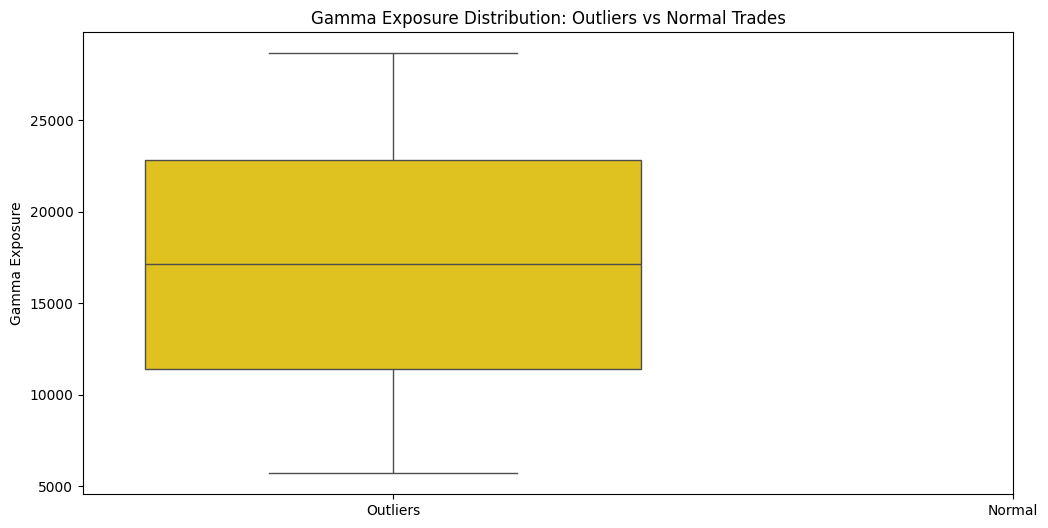

In [97]:
# Features to compare
features = ['Regime','Avg_IV','Gamma_Exposure','EMA_5','EMA_15','Delta_C','Vega_C','Fut_Basis','Spot_Return']

outliers = df[df['Outlier']==True]
normal = df[df['Outlier']==False]

# Boxplot example
plt.figure(figsize=(12,6))
sns.boxplot(data=[outliers['Gamma_Exposure'], normal['Gamma_Exposure']], palette=['gold','lightblue'])
plt.xticks([0,1], ['Outliers','Normal'])
plt.ylabel('Gamma Exposure')
plt.title('Gamma Exposure Distribution: Outliers vs Normal Trades')
plt.show()


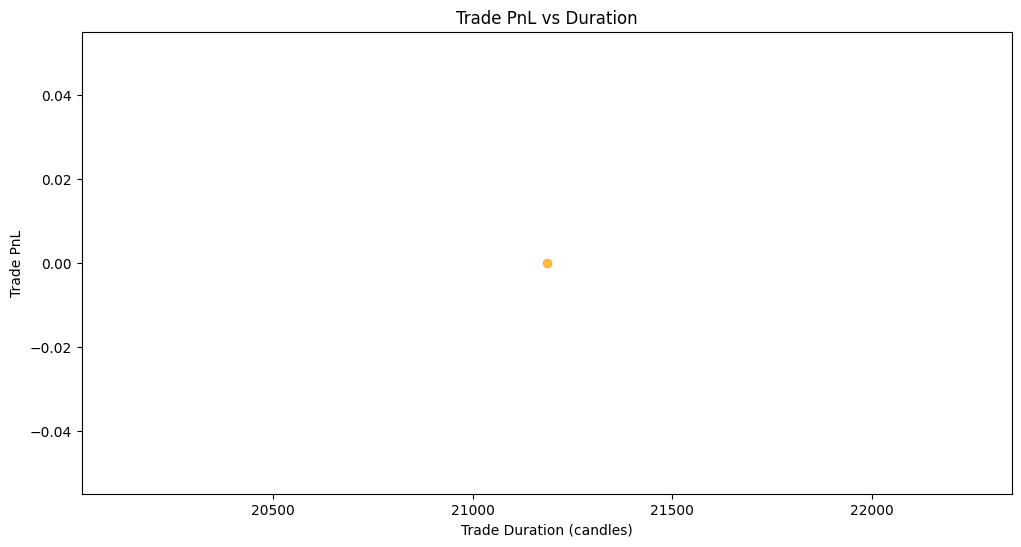

In [98]:
# Approx trade duration in candles
df['Trade_ID'] = (df['Signal'].diff()!=0).cumsum()
trade_duration = df.groupby('Trade_ID').size()
trade_pnl = df.groupby('Trade_ID')['Strategy_Return'].sum()

plt.figure(figsize=(12,6))
plt.scatter(trade_duration, trade_pnl, c='orange', alpha=0.7)
plt.xlabel('Trade Duration (candles)')
plt.ylabel('Trade PnL')
plt.title('Trade PnL vs Duration')
plt.show()


Please ensure that cells related to HMM regime detection (e.g., cell '4LrEmAQVS-ja') have been executed.


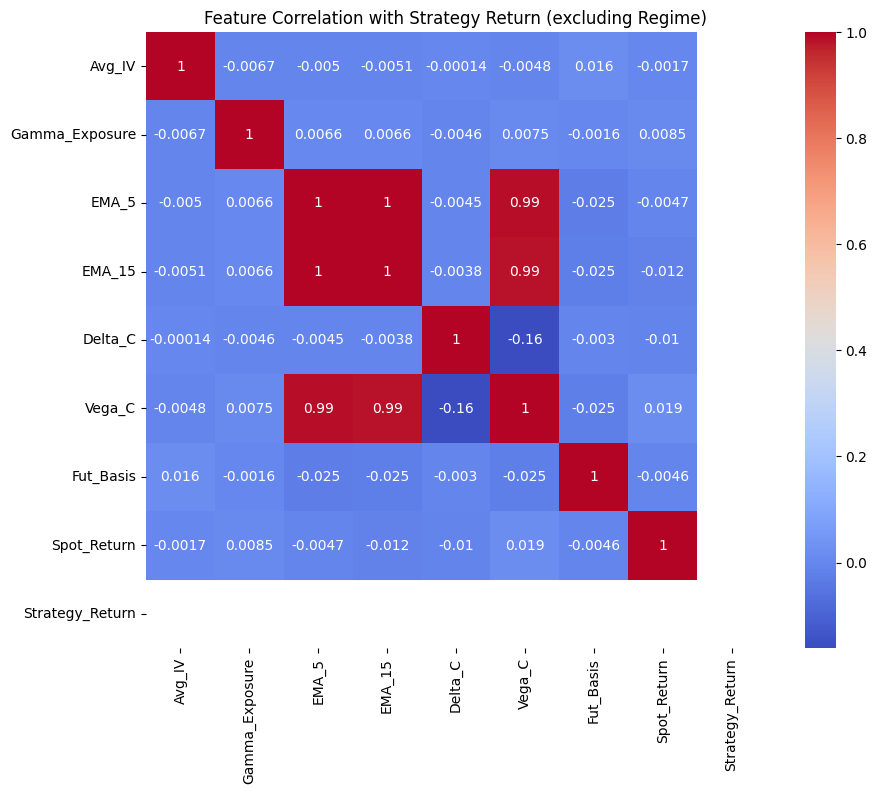

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# Features to compare (re-ensure definition and type)
features = ['Regime','Avg_IV','Gamma_Exposure','EMA_5','EMA_15','Delta_C','Vega_C','Fut_Basis','Spot_Return']

# Check if 'Regime' is in df.columns
current_features = list(features)
if 'Regime' not in df.columns:
    print("Warning: 'Regime' column not found in DataFrame 'df'.")
    print("Please ensure that cells related to HMM regime detection (e.g., cell '4LrEmAQVS-ja') have been executed.")
    # Remove 'Regime' from the list of features to plot if it's missing
    if 'Regime' in current_features:
        current_features.remove('Regime')

# Ensure 'Strategy_Return' is also present for correlation
if 'Strategy_Return' not in df.columns:
    print("Error: 'Strategy_Return' column not found. Cannot plot correlations.")
elif not current_features:
    print("No features available for correlation after checks. Skipping plot.")
else:
    plt.figure(figsize=(10,8))
    sns.heatmap(df[current_features + ['Strategy_Return']].corr(), annot=True, cmap='coolwarm')
    plt.title("Feature Correlation with Strategy Return" + (" (excluding Regime)" if 'Regime' not in df.columns else ""))
    plt.show()

In [107]:
total_trades = df['Signal'].diff().abs().sum()/2
outlier_trades = df['Outlier'].sum()
avg_pnl_outlier = outliers['Strategy_Return'].mean()
avg_pnl_normal = normal['Strategy_Return'].mean()

# Time-of-day pattern (hour)
df['Hour'] = df['Datetime'].dt.hour
hourly_pnl = df.groupby('Hour')['Strategy_Return'].sum()

print(f"Total Trades: {total_trades}")
print(f"Outlier Trades: {outlier_trades} ({outlier_trades/total_trades*100:.2f}%)")
print(f"Avg PnL Outlier: {avg_pnl_outlier:.4f}, Normal: {avg_pnl_normal:.4f}")
print("Hourly PnL Pattern:\n", hourly_pnl)


Total Trades: 0.0
Outlier Trades: 0 (nan%)
Avg PnL Outlier: nan, Normal: 0.0000
Hourly PnL Pattern:
 Hour
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: Strategy_Return, dtype: float64


/tmp/ipython-input-4073890736.py:11: RuntimeWarning: invalid value encountered in scalar divide
  print(f"Outlier Trades: {outlier_trades} ({outlier_trades/total_trades*100:.2f}%)")


In [106]:
# Part 3 ke end me
df.to_csv("/content/quant_trading_project/data/nifty_features_5min.csv", index=False)
print("Regime column saved successfully ✅")


Regime column saved successfully ✅
